In [1]:
import numpy as np
import cv2, os, glob, time, random
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib import cm

### Data 
I have used dataset labeled as [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) for this project. These images come from three sources : [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/) and a video from [Udacity](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/project_video.mp4).  

In [2]:
car_imgs = glob.glob("data/vehicles/*/*.*")
notcar_imgs = glob.glob("data/non-vehicles/*/*.*")

In [3]:
def data_info(images, display=None) :
    print("Number of images : ", len(images))
    example_img = mpimg.imread(images[0])
    print("Image shape : ", example_img.shape)
    print("Image data type : ", example_img.dtype)
    if display is not None :
        nrows,ncols = display
        n_imgs = nrows*ncols
        images_select = random.sample(images, n_imgs)
        fig, axes = plt.subplots(nrows,ncols, figsize=(2*ncols,2*nrows))
        for img,ax in zip(images_select, axes.flatten()) :
            img = mpimg.imread(img)
            ax.imshow(img)
            ax.axis('off')

**Vehicles**

Number of images :  8792
Image shape :  (64, 64, 3)
Image data type :  float32


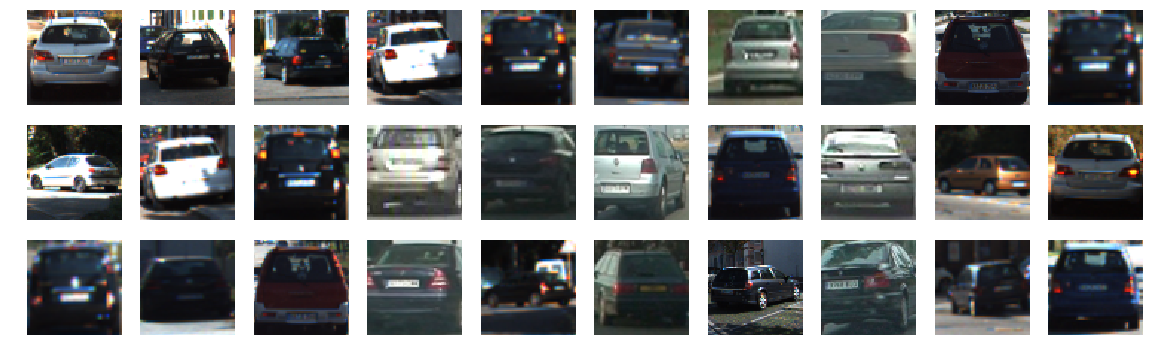

In [4]:
data_info(car_imgs, display=(3,10))

**non-vehicles**

Number of images :  8968
Image shape :  (64, 64, 3)
Image data type :  float32


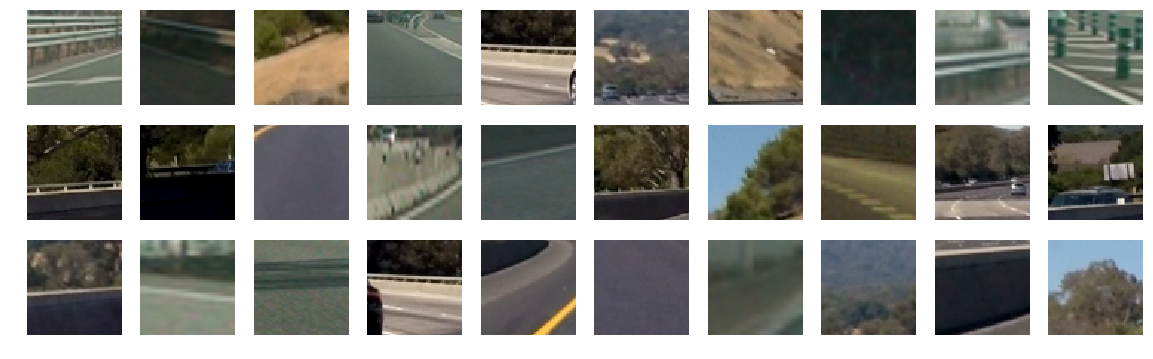

In [5]:
data_info(notcar_imgs, display=(3,10))

The two classes have roughly the same number of images resulting in a balanced dataset. 

### Train-test splitting
There is one issue : it turns out that many of the images in the dataset were taken in quick succession resulting in very similar images. Consequently, randomly splitting data into train and test sets will result in highly correlated images between the two datasets. To remedy this problem, I have made sure that images from same track do not end up in both training and test sets. The test data size is fixed to 20% of the full dataset. 


In [6]:
from sklearn.model_selection import train_test_split

# split vehicles data by selecting tracks manually for GTI data and randomly for KITTI data
car_train_indices = []
car_test_indices = []

def split_manual(DIR, indices):
    start,stop = indices
    img_files = glob.glob(os.path.join(DIR,"*.*"))
    for f in img_files :
        index = int(f.split("image")[1][:4])
        if start<=index<=stop :
            car_test_indices.append(car_imgs.index(f))
        else :
            car_train_indices.append(car_imgs.index(f))
            
def split_random(DIR, test_size=0.2) :
    img_files = glob.glob(os.path.join(DIR,"*.*"))
    train,test = train_test_split(img_files, test_size=test_size, random_state=0)
    car_train_indices.extend([car_imgs.index(f) for f in train])
    car_test_indices.extend([car_imgs.index(f) for f in test])

split_manual("data/vehicles/GTI_Far/", (605,799))
split_manual("data/vehicles/GTI_Left/", (9,183))
split_manual("data/vehicles/GTI_Far/", (191,397))
split_manual("data/vehicles/GTI_Far/", (803,974))
test_size = 1/(1+len(car_train_indices)/len(car_test_indices))
split_random("data/vehicles/KITTI_extracted/", test_size=test_size)
print("Number of images in vehicles training set : ", len(car_train_indices))
print("Number of images in vehicles test set : ", len(car_test_indices))
print("Test size is {:2.2f}% of total vehicles dataset".format(
        100/(1+len(car_train_indices)/len(car_test_indices))))
print("="*50)

# split non-vehicles data through random split
img_files = glob.glob(os.path.join("data/non-vehicles/*/*.*"))
notcar_train_indices, notcar_test_indices = train_test_split(range(len(notcar_imgs)), test_size=test_size,
                                                            random_state=0)
print("Number of images in non-vehicles training set : ", len(notcar_train_indices))
print("Number of images in non-vehicles test set : ", len(notcar_test_indices))
print("Test size is {:2.2f}% of total non-vehicles dataset".format(
        100/(1+len(notcar_train_indices)/len(notcar_test_indices))))

Number of images in vehicles training set :  7540
Number of images in vehicles test set :  1837
Test size is 19.59% of total vehicles dataset
Number of images in non-vehicles training set :  7211
Number of images in non-vehicles test set :  1757
Test size is 19.59% of total non-vehicles dataset


In [7]:
# dictionaries for exploring colorpsaces
cvtColor = {"RGB"  : cv2.COLOR_BGR2RGB, 
            "LUV"  : cv2.COLOR_BGR2LUV, 
            "YUV"  : cv2.COLOR_BGR2YUV,
            "HSV"  : cv2.COLOR_BGR2HSV,
            "HLS"  : cv2.COLOR_BGR2HLS,
            "YCrCb": cv2.COLOR_BGR2YCrCb}

# set range for color channels
histRange = {"RGB"  : [(0,256)]*3,
             "YCrCb": [(0,256)]*3,
             "YUV"  : [(0,256)]*3,
             "HSV"  : [(0,256)]*3,
             "HLS"  : [(0,256)]*3,
             "LUV"  : [(0,192),(0,256),(0,256)]}


# functions for changing between opencv format (BGR) and the default (RGB)
def BGR2RGB(img) :
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def RGB2BGR(img) :
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

---

### Histogram of Oriented Gradients (HOG)

Below is the code to extract hog features :

In [8]:
from skimage.feature import hog

# function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [9]:
def hog_features_visualize(data, channels=["R","G","B"], orient=9,
                          pix_per_cell = 8, cell_per_block = 2, hog_channel = "ALL") :
    cvt_color = cvtColor["".join(channels)]
    bins_range = histRange["".join(channels)]
    imgs = random.sample(data,3)
    fig, axes = plt.subplots(3,4,figsize=(15,12))
    for ax in axes.flatten() :
        ax.axis('off')
    for img,ax in zip(imgs,axes) :
        image = cv2.imread(img)
        ax[0].imshow(BGR2RGB(image))
        image = cv2.cvtColor(image, cvt_color)
        for i in range(image.shape[2]) :
            channel = np.maximum(image[:,:,i],0)
            features, hog_image = get_hog_features(channel, orient, pix_per_cell, 
                                            cell_per_block, vis=True, feature_vec=False)
            ax[i+1].imshow(hog_image)
    axes[0][0].set_title('Original')
    for i in range(3) :
        axes[0][i+1].set_title(channels[i]+' channel hog')

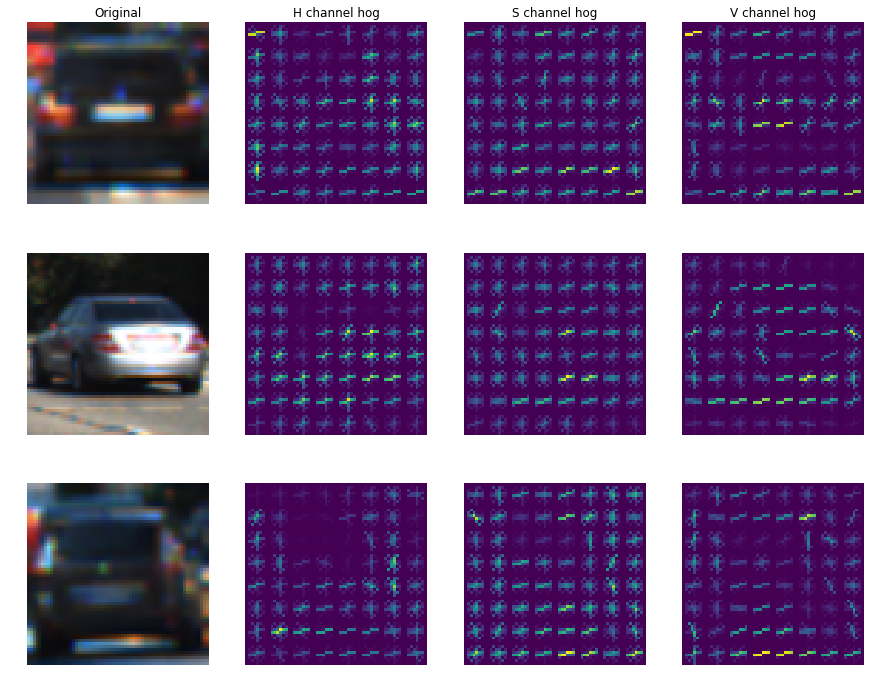

In [10]:
data = car_imgs
channels = ["H","S","V"]
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

hog_features_visualize(data, channels, orient, pix_per_cell, 
                       cell_per_block, hog_channel)

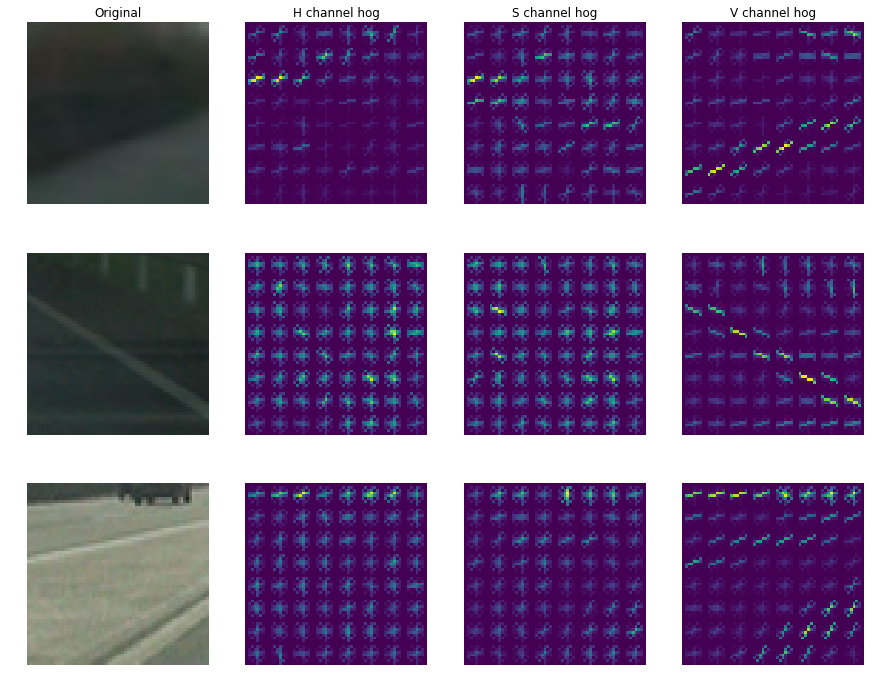

In [11]:
data = notcar_imgs
channels = ["H","S","V"]
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

hog_features_visualize(data, channels, orient, pix_per_cell, 
                       cell_per_block, hog_channel)

There are a number of HOG parameters that can be tuned. Three of these parameters determine the size of the feature vector : number of pixels per cell, number of cells per block and number of orientations. While a large feature vector in general carries more information, not all information may be useful for classification. From practical point of view, having too fine a grid or too many cells per block will reduce computational speed. Given that we have 64x64 images, a grid size of 8x8 (i.e. 8 pixels per cell) and 2 cells per block seems like a reasonable choice and amounts to 196 features per color channel per orientation. I used all three color channels as it gave a higher test prediction score. As seen above, gradient information is adequately captured and at the same time I found that speed is not compromised.

To find other parameters, linear SVM classifier will be used. Here is the code : 

In [12]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# function to extract features from a list of images
def extract_features(imgs, cvt_color, orient, pix_per_cell, 
                     cell_per_block, hog_channel):
    
    features = []
    for file in imgs:
        image = cv2.imread(file)
        feature_image = cv2.cvtColor(image, cvt_color)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    return np.array(features)

def SVC_hog(cvt_color=cvtColor["RGB"], orient=9, pix_per_cell=8, cell_per_block=2, 
            hog_channel="ALL", debug=True) :
    t=time.time()
    car_features = extract_features(car_imgs, cvt_color=cvt_color, orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, hog_channel=hog_channel)
    notcar_features = extract_features(notcar_imgs, cvt_color=cvt_color, orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, hog_channel=hog_channel)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors and normalize
    X_train = np.vstack((car_features[car_train_indices], 
                         notcar_features[notcar_train_indices])).astype(np.float64)   
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = np.vstack((car_features[car_test_indices], 
                         notcar_features[notcar_test_indices])).astype(np.float64) 
    X_test = standard_scaler.transform(X_test) # use same fit as training data

    # labels vector
    y_train = np.hstack((np.ones(len(car_train_indices)), np.zeros(len(notcar_train_indices))))
    y_test = np.hstack((np.ones(len(car_test_indices)), np.zeros(len(notcar_test_indices))))

    if debug :
        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    if debug :
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        sample = random.sample(range(len(y_test)), n_predict)
        print('My SVC predicts: ', svc.predict(X_test[sample]))
        print('For these',n_predict, 'labels: ', y_test[sample])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Check linear SVC sample timings and test predictions :

In [13]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # options : 0,1,2,"ALL"
cvt_color = cvtColor["YUV"]

SVC_hog(cvt_color=cvt_color, orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, hog_channel=hog_channel, debug=True)

68.57 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
14.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9944
My SVC predicts:  [ 1.  1.  0.  0.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  1.  1.  1.  0.  0.]
0.00159 Seconds to predict 10 labels with SVC


Next I investigate different colorspaces : 

In [14]:
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel="ALL" # options : 0,1,2,"ALL"

for color_space in cvtColor :
    print("="*50)
    print("Color space : ", color_space)
    SVC_hog(cvt_color=cvtColor[color_space], orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, hog_channel=hog_channel, debug=False)

Color space :  YUV
Test Accuracy of SVC =  0.9944
Color space :  LUV
Test Accuracy of SVC =  0.9928
Color space :  HLS
Test Accuracy of SVC =  0.9919
Color space :  HSV
Test Accuracy of SVC =  0.9925
Color space :  RGB
Test Accuracy of SVC =  0.9825
Color space :  YCrCb
Test Accuracy of SVC =  0.9942


**YUV colorspace** gives highest score.  

Next, I will find the optimal number of orientation bins :

In [15]:
pix_per_cell=8
cell_per_block=2
hog_channel="ALL" # options : 0,1,2,"ALL"
cvt_color=cvtColor["YUV"]

for orient in [8,9,10,11] :
        print("="*50)
        print("Orientation bins : ", orient)
        SVC_hog(cvt_color=cvt_color, orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, hog_channel=hog_channel, debug=False)

Orientation bins :  8
Test Accuracy of SVC =  0.9933
Orientation bins :  9
Test Accuracy of SVC =  0.9944
Orientation bins :  10
Test Accuracy of SVC =  0.9944
Orientation bins :  11
Test Accuracy of SVC =  0.9961


Optimal **number of orientation bins = 11**

---

### Color features

Two types of color features are considered : 
* Spatial binning of color channels
* Histogram of color channels 

Relevant code can be found below :

In [16]:
# function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=[(0, 256)]*3, visualize=False):
    channel_hist = [np.histogram(img[:,:,i], bins=nbins, range=bins_range[i]) for i in range(img.shape[2])]
    bin_edges = [hist[1] for hist in channel_hist]
    channel_hist = [hist[0] for hist in channel_hist]
    hist_features = np.concatenate(channel_hist)
    if visualize :
        return (channel_hist, bin_edges, hist_features) 
    else :
        return hist_features

Here are some examples of color histograms using HSV colorspace for *vehicles* and *non-vehicles* datasets :

In [17]:
def color_features_visualize(data, channels=["R","G","B"], nbins=32) :
    cvt_color = cvtColor["".join(channels)]
    bins_range = histRange["".join(channels)]
    imgs = random.sample(data,3)
    fig, axes = plt.subplots(3,4,figsize=(16,8))
    for img,ax in zip(imgs,axes) :
        image = cv2.imread(img)
        ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[0].axis('off')
        image = cv2.cvtColor(image, cvt_color)
        bins_range = bins_range
        nbins=nbins
        channel_hist, bin_edges, hist_features = color_hist(image, nbins=nbins, 
                                                bins_range=bins_range, visualize=True)
        width=[(b[1]-b[0]) for b in bin_edges]
        for i in range(len(channel_hist)):
            ax[i+1].bar(bin_edges[i][:-1],channel_hist[i],width=width[i])
    axes[0][0].set_title('Original')
    for i in range(3) :
        axes[0][i+1].set_title(channels[i]+' channel histogram')

**vehicles : **

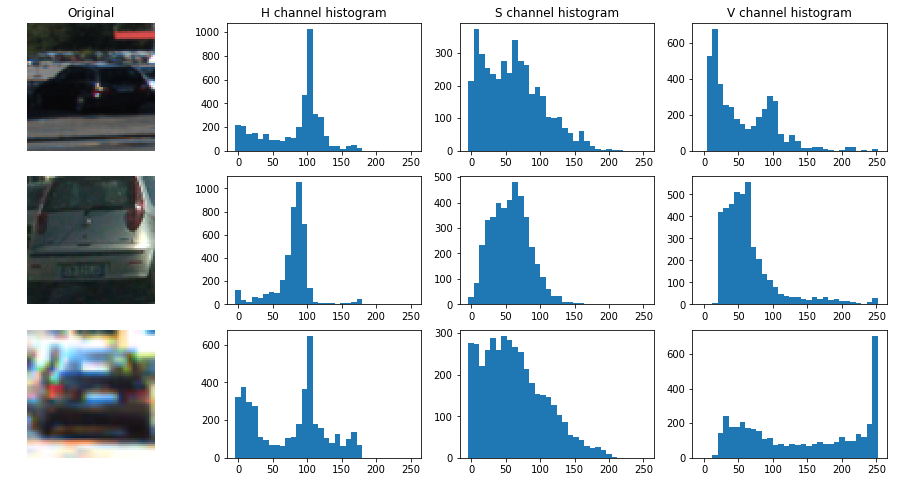

In [18]:
data = car_imgs
channels = ["H","S","V"]
nbins=32

color_features_visualize(data, channels, nbins)

**non-vehicles : **

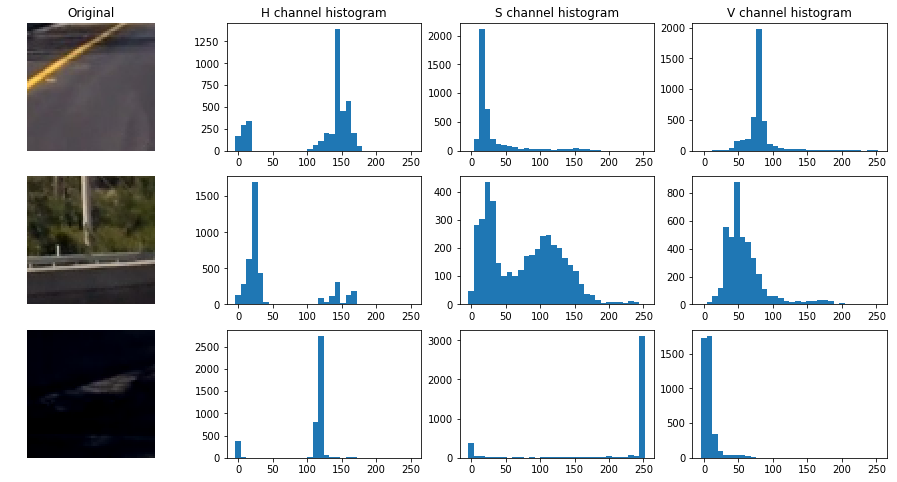

In [19]:
data = notcar_imgs
channels = ["H","S","V"]
nbins=32

color_features_visualize(data, channels, nbins)

Some differences between the two datasets are clearly visible.

There are two other parameters : number of spatial bins and number of histogram bins. 

To find the optimal parameters, linear SVM classifier will be used. Here is the code : 

In [20]:
# function to extract features from a list of images
def extract_features(imgs, cvt_color, spatial_size, hist_bins, hist_range):
    
    features = []
    for file in imgs:
        image = cv2.imread(file)
        color_feature_image = cv2.cvtColor(image, cvt_color)   
        spatial_features = bin_spatial(color_feature_image, size=spatial_size)
        hist_features = color_hist(color_feature_image, nbins=hist_bins, bins_range=hist_range)
        # combine all features
        features.append(np.concatenate((spatial_features, hist_features)))
    return np.array(features)


def SVC_color(cvt_color=cvtColor['RGB'], spatial=32, histbin=32, hist_range=[(0, 256)]*3, debug=True) :
    t = time.time()
    car_features = extract_features(car_imgs, cvt_color=cvt_color, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range)
    notcar_features = extract_features(notcar_imgs, cvt_color=cvt_color, spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=hist_range)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to extract color features...')
    
    X_train = np.vstack((car_features[car_train_indices], 
                         notcar_features[notcar_train_indices])).astype(np.float64)   
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = np.vstack((car_features[car_test_indices], 
                         notcar_features[notcar_test_indices])).astype(np.float64) 
    X_test = standard_scaler.transform(X_test) # use same fit as training data

    # labels vector
    y_train = np.hstack((np.ones(len(car_train_indices)), np.zeros(len(notcar_train_indices))))
    y_test = np.hstack((np.ones(len(car_test_indices)), np.zeros(len(notcar_test_indices))))

    if debug :
        print('Using : ', spatial, ' spatial bins and ', histbin,' histogram bins')
        print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    if debug :
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        sample = random.sample(range(len(y_test)), n_predict)
        print('My SVC predicts: ', svc.predict(X_test[sample]))
        print('For these',n_predict, 'labels: ', y_test[sample])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Check linear SVC sample timings and test predictions :

In [21]:
spatial = 32
histbin = 32
cvt_color = cvtColor["YUV"]
hist_range=histRange["YUV"]

SVC_color(cvt_color=cvt_color, spatial=spatial, histbin=histbin, hist_range=hist_range, debug=True)

11.05 Seconds to extract color features...
Using :  32  spatial bins and  32  histogram bins
Feature vector length: 3168
14.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9752
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  1.]
0.00181 Seconds to predict 10 labels with SVC


Next I investigate different colorspaces : 

In [22]:
spatial = 32
histbin = 32

for color_space in cvtColor :
    print("="*50)
    print("Color space : ", color_space)
    SVC_color(cvt_color=cvtColor[color_space], spatial=spatial, histbin=histbin, 
              hist_range=histRange[color_space], debug=False)

Color space :  YUV
Test Accuracy of SVC =  0.9752
Color space :  LUV
Test Accuracy of SVC =  0.9761
Color space :  HLS
Test Accuracy of SVC =  0.9672
Color space :  HSV
Test Accuracy of SVC =  0.9713
Color space :  RGB
Test Accuracy of SVC =  0.9722
Color space :  YCrCb
Test Accuracy of SVC =  0.9716


**LUV colorspace** gives the highest score.  

Next, I will find the optimal number of spatial and histogram bins :

In [23]:
cvt_color = cvtColor["HSV"]
hist_range = histRange["HSV"]

for spatial in [8,16,32] :
    for histbin in [16,32,64] :
        print("="*50)
        print("Number of spatial bins : ", spatial)
        print("Number of color histogram bins : ", histbin)
        SVC_color(cvt_color=cvt_color, spatial=spatial, histbin=histbin, 
                  hist_range=hist_range, debug=False)

Number of spatial bins :  8
Number of color histogram bins :  16
Test Accuracy of SVC =  0.9574
Number of spatial bins :  8
Number of color histogram bins :  32
Test Accuracy of SVC =  0.9669
Number of spatial bins :  8
Number of color histogram bins :  64
Test Accuracy of SVC =  0.9761
Number of spatial bins :  16
Number of color histogram bins :  16
Test Accuracy of SVC =  0.9666
Number of spatial bins :  16
Number of color histogram bins :  32
Test Accuracy of SVC =  0.9694
Number of spatial bins :  16
Number of color histogram bins :  64
Test Accuracy of SVC =  0.9769
Number of spatial bins :  32
Number of color histogram bins :  16
Test Accuracy of SVC =  0.9641
Number of spatial bins :  32
Number of color histogram bins :  32
Test Accuracy of SVC =  0.9716
Number of spatial bins :  32
Number of color histogram bins :  64
Test Accuracy of SVC =  0.978


Optimal number of spatial bins = 32 and number of color histogram bins = 64

---

### Final classifier

HOG, color histogram and spatial features were combined into a single 1-D *feature vector* using parameters determined before. Here, I summarize the parameters again :

* *colorspace = YUV*
* *orientations = 11*
* *pixels per cell = (8,8)*
* *cells per block = (2,2)*
* *color histogram bins = 64 per color channel*  
* *spatial bins = (32,32)*

I explored colorspaces for the combined feature vector. YUV still gives the best overall test scores.

In [24]:
from skimage.feature import hog


# function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
        
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=[(0, 256)]*3, visualize=False):
    channel_hist = [np.histogram(img[:,:,i], bins=nbins, range=bins_range[i]) for i in range(img.shape[2])]
    bin_edges = [hist[1] for hist in channel_hist]
    #bin_centers = (bin_edges[1:]  + bin_edges[:-1])/2
    channel_hist = [hist[0] for hist in channel_hist]
    hist_features = np.concatenate(channel_hist)
    if visualize :
        return (channel_hist, bin_edges, hist_features) 
    else :
        return hist_features

# function to extract features from a list of images
def extract_features(imgs):
    # parameters
    orient=11
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    color="YUV"
    cvt_color = cvtColor[color]
    bins_range = histRange[color]
    
    features = []
    for file in imgs:
        image = cv2.imread(file)
        feature_image = cv2.cvtColor(image, cvt_color)
        # HOG features
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
        # spatial and color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=bins_range)
        # combine all features
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    return np.array(features)

Cross-validation is used to determine the penalty parameter 'C' in the linear SVM classifier : 

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


t=time.time()
car_features = extract_features(car_imgs)
notcar_features = extract_features(notcar_imgs)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract all features...')
# Create an array stack of feature vectors and normalize
X_train = np.vstack((car_features[car_train_indices], 
                         notcar_features[notcar_train_indices])).astype(np.float64)   
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = np.vstack((car_features[car_test_indices], 
                     notcar_features[notcar_test_indices])).astype(np.float64) 
X_test = standard_scaler.transform(X_test) # use same fit as training data

# labels vector
y_train = np.hstack((np.ones(len(car_train_indices)), np.zeros(len(notcar_train_indices))))
y_test = np.hstack((np.ones(len(car_test_indices)), np.zeros(len(notcar_test_indices))))

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
#svc = LinearSVC()
clf = GridSearchCV(LinearSVC(), param_grid={'C':np.logspace(-3,-2,5)})
# Check the training time for the SVC
t=time.time()
clf = clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print("CV results : ", clf.best_estimator_)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
sample = random.sample(range(len(y_test)), n_predict)
print('My SVC predicts: ', clf.predict(X_test[sample]))
print('For these',n_predict, 'labels: ', y_test[sample])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

74.93 Seconds to extract all features...
Feature vector length: 9732
164.22 Seconds to train SVC...
CV results :  LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Test Accuracy of SVC =  0.9978
My SVC predicts:  [ 0.  1.  0.  0.  0.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  1.  1.  1.  0.  1.]
0.00203 Seconds to predict 10 labels with SVC


Test set accuracy of **99.8%** was obtained. 

---

### Sliding window

Next, sliding-window technique is used to find cars in video frames using the trained classifier from above. Only region below the horizon is selected for searching vehicles. Four scales were chosen, each with their own search area :

| Scale			| y-range		|
| ------------- |:-------------:|
|  1.0			| (380,508)		|
|  1.5  		| (380,572)		| 
|  2.0  		| (380,636)		| 
|  2.5 			| (380,700)		| 
where default `scale=1.0` corresponds to window size of 64x64 pixels. Note that `y=380` is approximately the horizon position.  

In [26]:
def find_cars(img, ystart, ystop, scale, clf, X_scaler):
    
    # parameters
    orient=11
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    color="YUV"
    cvt_color = cvtColor[color]
    bins_range = histRange[color] 
    
    #img = img.astype(np.float32)/255
    draw_img = np.copy(img)
    
    
    img_tosearch = img[ystart:ystop,:,:]
    img_tosearch = cv2.cvtColor(img_tosearch, cvt_color)
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=bins_range)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,
                                                          hog_features)).reshape(1, -1))       
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (0,0,1),6)
                bbox_list.append(((xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return bbox_list



def draw_boxes(img, bbox_list, color=(0,0,255)):
    for box in bbox_list :
        cv2.rectangle(img, box[0], box[1], color,6)
    return img
    

# sliding window scales and the search y-range
y_range = {1.0 : (380,508), 
           1.5 : (380,572), 
           2.0 : (380,636), 
           2.5 : (380,700)} 

Using sliding windows with the four scales (each scale shown with a different color) and parameters described above, here are the results on some test images :

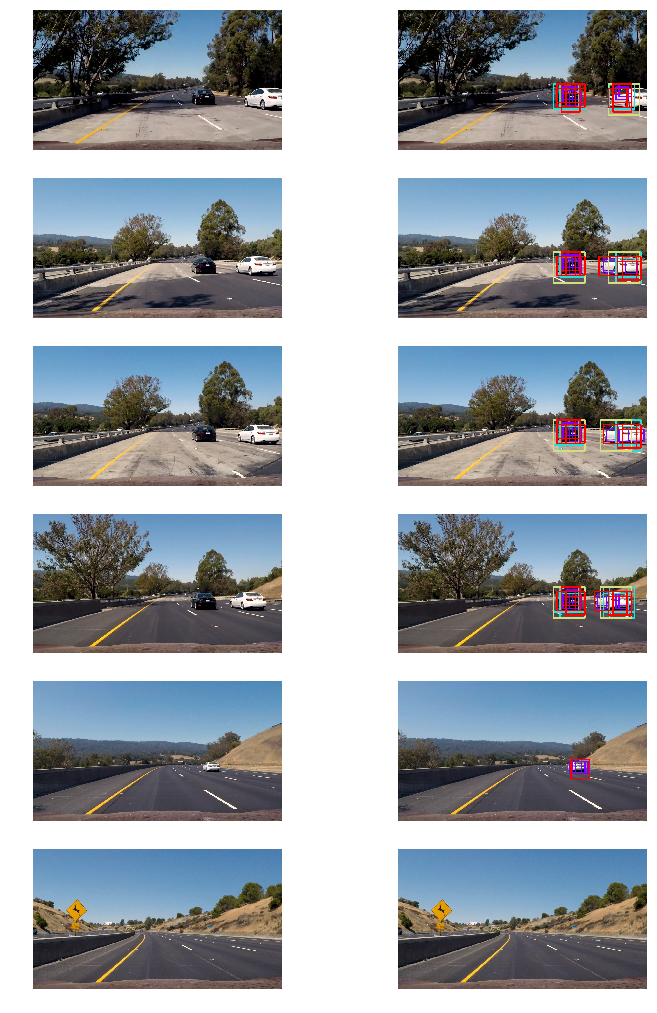

In [27]:
test_imgs = glob.glob("test_images/*.jpg")
nrows = len(test_imgs)
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
for ax in axes.flatten():
    ax.axis('off')
for image, ax in zip(test_imgs, axes):
    img = cv2.imread(image)
    out_img = np.copy(BGR2RGB(img))
    ax[0].imshow(BGR2RGB(img))
    for scale, i_color in zip(y_range.keys(), np.linspace(0,1,4)) :
        ystart,ystop = y_range[scale]
        color = tuple(255*c for c in plt.cm.rainbow(i_color)[:3])
        bbox_list = find_cars(img, ystart, ystop, scale, clf, standard_scaler)
        out_img = draw_boxes(out_img, bbox_list,color)
    ax[1].imshow(out_img)

### Heatmaps

After positive detections in each image, the last step is to combine the detections to actually identify vehicle locations. For this step,  I created a heatmap and then thresholded that map to identify vehicle positions.  `scipy.ndimage.measurements.label()` function was used to identify individual blobs in the heatmap. Under the assumption that each blob corresponds to a vehicle, I constructed bounding boxes to cover the area of each blob detected. 

In [28]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    return img

Here's an example result showing heatmap using `theshold=2` on individual test images, followed by the resulting bounding boxes :

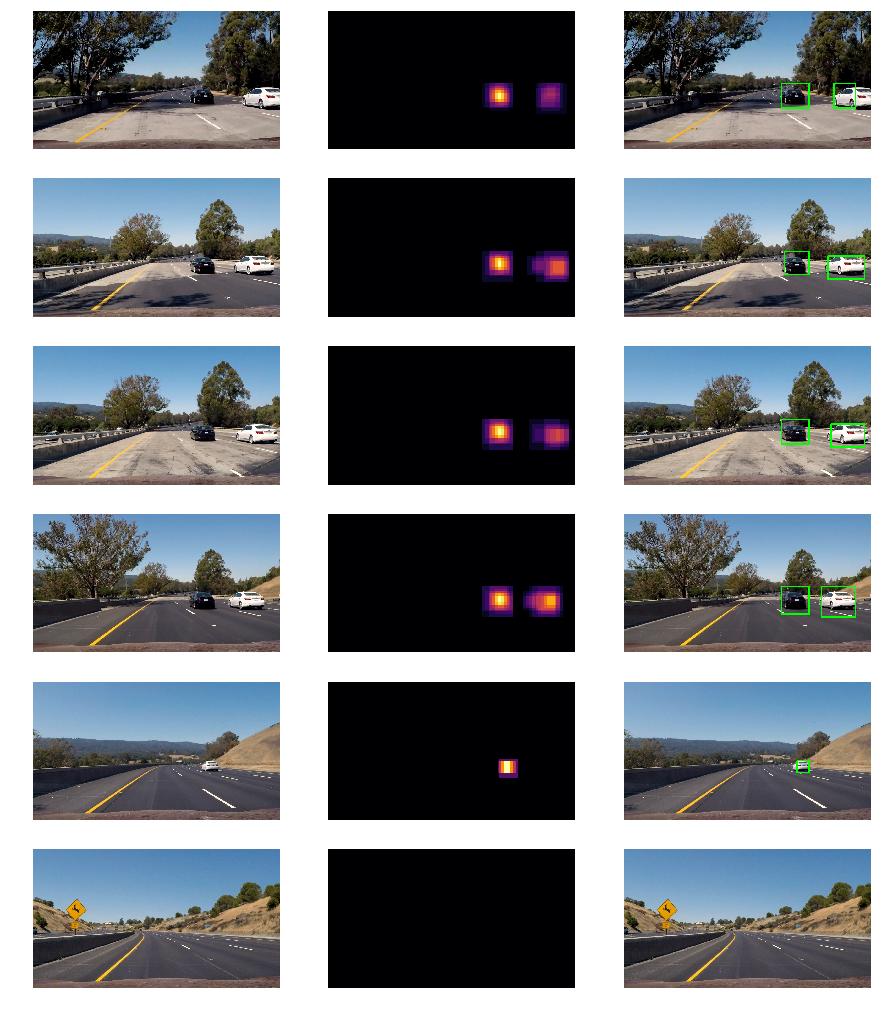

In [29]:
from scipy.ndimage.measurements import label


test_imgs = glob.glob("test_images/*.jpg")
nrows = len(test_imgs)
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows))
for ax in axes.flatten():
    ax.axis('off')
for image, ax in zip(test_imgs, axes):
    img = cv2.imread(image)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    out_img = np.copy(BGR2RGB(img))
    ax[0].imshow(BGR2RGB(img))
    for scale, i_color in zip(y_range.keys(), np.linspace(0,1,len(y_range))) :
        ystart,ystop = y_range[scale]
        bbox_list = find_cars(img, ystart, ystop, scale, clf, standard_scaler)
        out_img = draw_boxes(out_img, bbox_list,color)
        heat = add_heat(heat,bbox_list)
    ax[1].imshow(heat, cmap=plt.cm.inferno)
    heat = apply_threshold(heat,2)  
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(BGR2RGB(img)), labels)
    ax[2].imshow(draw_img)

### Video implementation

To make the video implementation more robust against false positives, a slight modification of above procedure is implemeted :

* First, the sliding window technique is applied to each frame of the video and the resulting detections upto 25 frames (or 1 second) are stored in memory.  
* Heatmap is constructed using the last 25 frames and a `threshold=8` is applied. 
* Using `scipy.ndimage.measurements.label()`, blobs in the heatmap from last step are identified as vehicles and bounding boxes drawn. 
* Updates to the heatmap are performed every 2 frames. If a vehicle was detected in previous update, a small bias in the heatmap is applied at the positions where vehicles were last detected. 

In [30]:
video_dim = (1280, 720)

class vehicle_detection :
    def __init__(self, n_iter=25, n_update=2, threshold=8) :
        self.count = 0
        # bboxes for every frame
        self.out_img = None
        # labeled bboxes 
        self.out_img_labeled = None
        # vehicle labels 
        self.labels = [None,0]
        # list of bbox lists from last n iterations
        self.bbox_list_n = [] 
        # number of frames to smooth over
        self.n_iter = n_iter
        # number of frames after which to update detection
        self.n_update = n_update
        # threshold for heat map
        self.threshold = threshold
        # heat map
        self.heat = np.zeros(video_dim[::-1])
        self.heatmap = np.copy(self.heat)
    
    def process_image(self, image) :
        self.count += 1
        self.image=image
        out_img = np.copy(image)
        img = RGB2BGR(image)
        for scale, i_color in zip(y_range.keys(), np.linspace(0,1,len(y_range))) :
            ystart,ystop = y_range[scale]
            bbox_list = find_cars(img, ystart, ystop, scale, clf, standard_scaler)
            color = tuple(255*c for c in plt.cm.rainbow(i_color)[:3])
            self.out_img = draw_boxes(out_img, bbox_list,color)
        self.bbox_list_n.append(bbox_list)
        if self.count%self.n_update == 0 :
            for bbox_list in self.bbox_list_n :
                self.heat = add_heat(self.heat,bbox_list)
            self.heat = apply_threshold(self.heat,self.threshold)
            self.heatmap = np.clip(self.heat, 0, 255)
            self.labels = label(self.heatmap)
            self.heat = np.clip(self.labels[0],0,1)*2
        if len(self.bbox_list_n)>self.n_iter :
            self.bbox_list_n.pop(0)
        self.out_img_labeled = draw_labeled_bboxes(np.copy(image), self.labels)
        return self.out_display()
    

    def out_display(self) :
        imgA = cv2.resize(self.out_img, None, fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
        imgB = np.uint8(self.heatmap*255/(0.001+np.max(self.heatmap)))
        imgB = cm.inferno(imgB)[:,:,:3]*255
        imgB = imgB.astype(np.uint8)
        imgB = cv2.addWeighted(imgB, 1, self.image, 0.4, 0)
        imgB = cv2.resize(imgB, None, fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
        hA,wA = imgA.shape[:2]
        h_text = int(video_dim[1]/2-hA)
        textA = np.zeros((h_text, wA,3), dtype=np.uint8)
        textB = np.zeros((video_dim[1]-h_text-2*hA, wA,3), dtype=np.uint8)
        textA[:,:,1] = 200
        textB[:,:,1] = 200
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(textA,'Bounding boxes',(10,h_text-20), font,1,(0,0,0),3,cv2.LINE_AA)
        cv2.putText(textB,'Heatmap',(10,h_text-20), font,1,(0,0,0),3,cv2.LINE_AA)
        img_combined_right = np.vstack((textA,imgA,textB,imgB))
        return np.hstack((self.out_img_labeled, img_combined_right))

In [31]:
# vd = vehicle_detection(n_iter=1,n_update=1,threshold=2)
# test_imgs = glob.glob("test_images/*.jpg")
# nrows = len(test_imgs)
# ncols = 2
# fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
# for image, ax in zip(test_imgs, axes):
#     img = mpimg.imread(image)
#     ax[0].imshow(img)
#     ax[1].imshow(vd.process_image(img))

---

### Final video output

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vd = vehicle_detection()
output = 'output_video/project_video.mp4'
clip = VideoFileClip("video/project_video.mp4")
clip = clip.fl_image(vd.process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [18:17<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 24min 40s, sys: 10.5 s, total: 24min 50s
Wall time: 18min 18s
